In [26]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import gc
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

In [27]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
BATCH_SIZE = 16
EPOCHS=5
n_splits=5
fold_selected=1 # 1..5

BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR = 'input/uw-madison-gi-tract-image-segmentation/train'
TRAIN_CSV = 'input/uw-madison-gi-tract-image-segmentation/train.csv'

In [29]:
df = pd.read_csv(TRAIN_CSV)
print(df.shape)

(115488, 3)


In [30]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
#--------------------------------------------------------------------------
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

#--------------------------------------------------------------------------
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
#--------------------------------------------------------------------------
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
df.head(5)

,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,input/uw-madison-gi-tract-image-segmentation/t...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,input/uw-madison-gi-tract-image-segmentation/t...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,input/uw-madison-gi-tract-image-segmentation/t...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,input/uw-madison-gi-tract-image-segmentation/t...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,input/uw-madison-gi-tract-image-segmentation/t...,266,266


In [31]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':df['id'][::3]})

# Warum :3? 
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
27373,case81_day0_slice_0142,,,,input/uw-madison-gi-tract-image-segmentation/t...,81,0,0142,266,266,0
26877,case131_day23_slice_0078,45147 3 45506 5 45865 7 46225 7 46585 8 46945 ...,45929 11 46288 25 46647 27 47007 29 47367 29 4...,,input/uw-madison-gi-tract-image-segmentation/t...,131,23,0078,360,310,2
24135,case35_day12_slice_0024,,,,input/uw-madison-gi-tract-image-segmentation/t...,35,12,0024,276,276,0
19627,case24_day25_slice_0076,21963 10 22228 13 22494 16 22759 19 23025 20 2...,24576 4 24840 7 25104 9 25143 8 25368 11 25407...,20346 3 20608 14 20872 17 21136 20 21401 22 21...,input/uw-madison-gi-tract-image-segmentation/t...,24,25,0076,266,266,3
4334,case15_day20_slice_0015,,,,input/uw-madison-gi-tract-image-segmentation/t...,15,20,0015,266,266,0


In [32]:
# HELPER FUNCTIONS

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

In [46]:
# Get Generator 
class DataGenerator(tf.keras.utils.Sequence):
    # einfach nur n konstruktor
    def __init__(self, df, batch_size = BATCH_SIZE, width=128, height=128, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.on_epoch_end()

    # ohne self = static
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,self.width,self.height,3))
        y = np.empty((self.batch_size,self.width,self.height,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    masks = cv2.resize(masks, (self.width, self.height))
                    y[i,:,:,k] = masks
        if self.subset == 'train': return X, y
        else: return X
        
        
    # lädt bild und resized es     
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
        

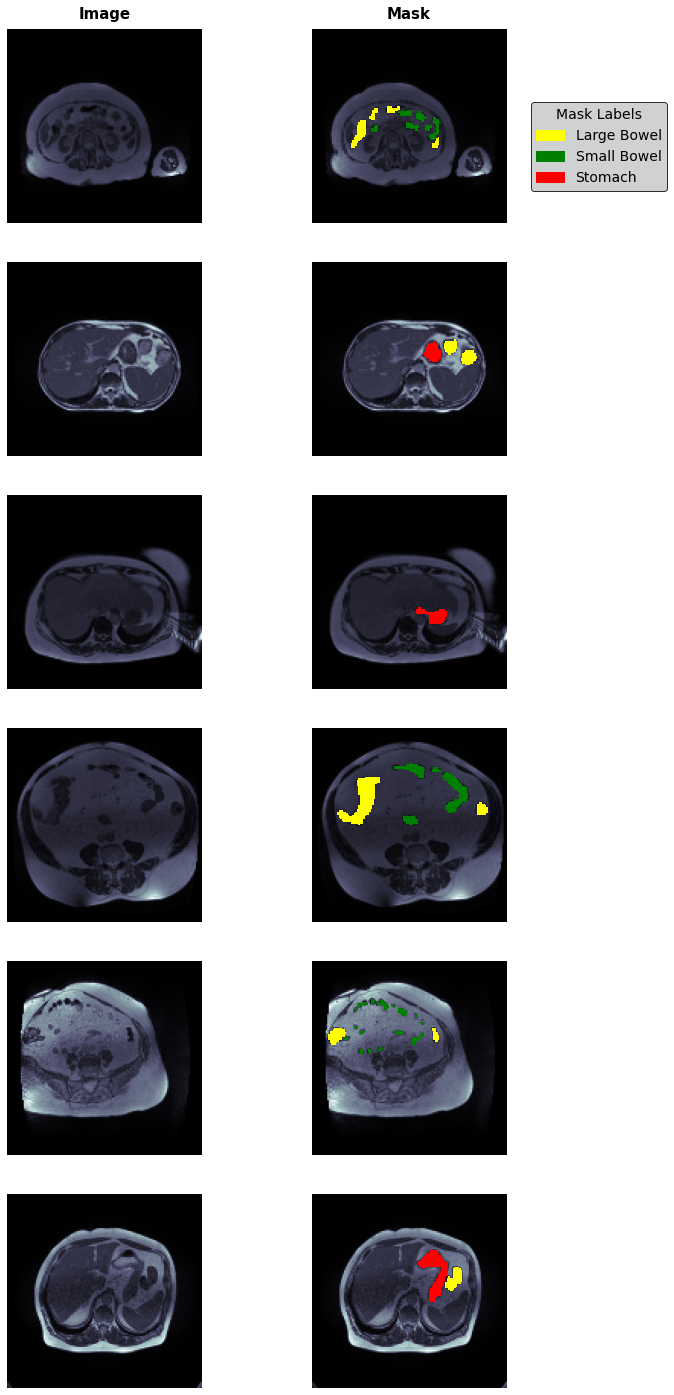

In [50]:
# Visualize Slices
# SAMPLES
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True,width=128, height=128)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

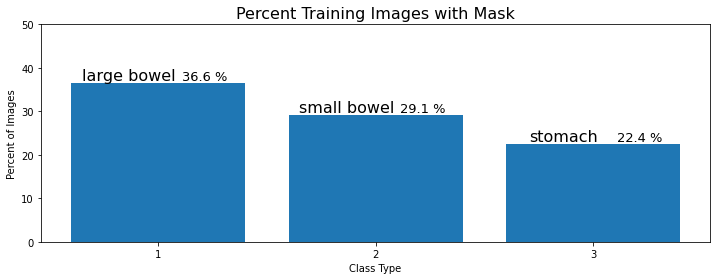

In [53]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

In [12]:
# Cross Validation
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [13]:
display(df_train.groupby(['fold','count'])['id'].count())


fold  count
1     0        4486
      1         485
      2        2230
      3         719
2     0        3847
      1         347
      2        1876
      3         554
3     0        4604
      1         576
      2        2138
      3         634
4     0        4862
      1         734
      2        2400
      3         628
5     0        4107
      1         326
      2        2277
      3         666
Name: id, dtype: int64

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])

In [ ]:
# Loss
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

# UNet

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

In [19]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
DEBUG = False

if DEBUG:
    custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss  
    }
    new_model = load_model('model.h5', custom_objects=custom_objects)

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False, 
    workers=4,
    epochs=EPOCHS
)

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [24]:
inputs = keras.Input(shape=(128,128) + (3,))
inputs.shape

TensorShape([None, 128, 128, 3])